<a href="https://colab.research.google.com/github/Shiwei-Chen/ISTM-660/blob/master/Text_Analytics_ICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

This project outlines a text-mining classification model using bag-of-words and logistic regression. The project is trying to understand the relationship between ratings and text reviews of a Women’s Clothing E-Commerce. 

Data Source:https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews


- Preliminary Analysis
- Formatting / Converting Text
- Logistic Regression
- Testing / Conclusions

In [0]:
#Import data
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [0]:
url = 'https://raw.githubusercontent.com/Shiwei-Chen/ISTM-660/master/Womens%20Clothing%20E-Commerce%20Reviews.csv'

df = pd.read_csv(url)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [0]:
#Choose useful data
df2 = df[['Review Text', 'Rating']]
df = df2
df.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


Since this project will explore the relationship between text reviews and ratings, only two columns will be kept to be used for exploration.

**Null Check**

In [0]:
null_count = df.isnull().sum()
null_count

Review Text    845
Rating           0
dtype: int64

There are 845 nulls in Review Text column, and these should be removed. 

In [0]:
df2 = df.dropna()
null_count = df2.isnull().sum()
null_count

Review Text    0
Rating         0
dtype: int64

The nulls have been removed. 

In [0]:
df = df2
#Rename since there is a space in column name 'Review Text'
re_name ={'Review Text':'review_text', 'Rating':'rating'}
df.rename(columns=re_name, inplace = True)
df.head()

,review_text,rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


# **Basic Statistics**

In [0]:
df.describe()

,rating
count,22641.000000
mean,4.183561
std,1.115762
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


It appears that this Women Clothing E-Commerce is doing a good job, because the mean is 4.183 and 75% mark is a 5 star review. This tells us there are a disproportionate amount of 5 star reviews. 

**Purpose of The Model**

This project will build a model using the bag of words / logistic regression model: 
- To gauge the sentiment of future text reviews and categorize them into “Good” or “Bad” classes.
- To pinpoint specific words with a high impact on rating sentiment. 

**Distribution**

The visualization of the data's distribution. 

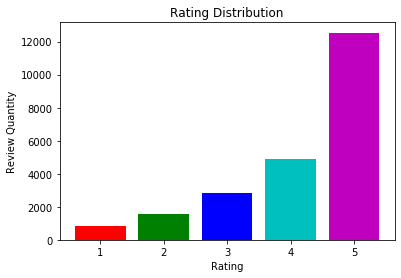

In [0]:
groups = df.groupby('rating').count()
Values = groups.review_text
colors = ['r', 'g', 'b', 'c', 'm']
plt.bar(([1,2,3,4,5]), Values, color= colors)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Review Quantity')
plt.show()

**Logidtic Regression**

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. In this case, the binary dependent variable is 'good' or 'bad' reviews, with the effect of many other independent variables.

**Sentiment Rule**

In order to perform the logistic regression later,it is necessary to figure out a way to turn these 5 ratings categories into binary classes (1 and 0). Logistic regression only handles “either/or” target variables. The best way to turn the star ratings into binary classes is:

- Set ratings below 3 stars as class 0 (negative sentiment)
- Set ratings above 3 as class 1 (positive sentiment)
- Delete the 3 star ratings. 

*3 stars are neutral and offer no sentiment insight.

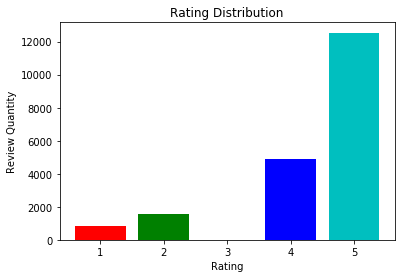

In [0]:
#dropping 3 
df = df[df.rating != 3]
groups = df.groupby('rating').count()
Values = groups.review_text
colors = ['r', 'g', 'b', 'c']
plt.bar(([1,2,4,5]), Values, color= colors) #do not put 3 in []
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Review Quantity')
plt.show()

In [0]:
#Creating binary class column
df['binary_class'] = np.where(df['rating'] > 3, 1, 0)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,review_text,rating,binary_class
0,Absolutely wonderful - silky and sexy and comf...,4,1
1,Love this dress! it's sooo pretty. i happene...,5,1
3,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,This shirt is very flattering to all due to th...,5,1
5,"I love tracy reese dresses, but this one is no...",2,0
...,...,...,...
23477,I'm so impressed with the beautiful color comb...,4,1
23478,I was surprised at the positive reviews for th...,1,0
23479,So i wasn't sure about ordering this skirt bec...,5,1
23481,I was very happy to snag this dress at such a ...,5,1


# **Formatting/Converting Text**

**Train/Test Split**

The first step in this process is separating our data into training and testing sets. We will create our model from the training data and save some instances for testing purposes later. We’re using sklearn to shuffle and split. Without messing with the parameters, it should split our data into 75% training and 25% testing.

By calling X_train.shape, we can check this. Further, let’s print a random review to verify it worked and to remind ourselves what we’re working with.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['review_text'], df['binary_class'], random_state = 0)
number = random.randint(1,1000)
print ('Random Review:')
print(' ')
print(X_train[number])
print(' ')
print('X_train shape: ' + str(X_train.shape))

Random Review:
 
Like the other reviewer said this top is extremely wide and boxy. it must be pinned in the picture online. it's very frustrating when they do that. thank goodness i didn't pay for shipping! for reference, i'm 5'2 and 135 pounds and bought the xxs, it's going back for sure. i'm trying to lose baby weight, not trying to look pregnant!
 
X_train shape: (14863,)


**Turning words into numbers**

Now comes the exciting part, translating our text data into numerical features. In order to run a regression though this data later, we need to have a feature for every word in our sample. Essentially, we will be translating each word to be assigned as a number and then counting the frequency of these word/numbers used per instance in matrices. The process of doing this is called “Bag-of-words”. It’s important to note that the order of words doesn’t matter, bag-of-words only counts the frequency per instance of words used. To start, we will use the Sklearn CountVectorizer

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)
vect.get_feature_names()[1:10]

['000', '00p', '02', '03', '03dd', '0in', '0p', '0petite', '0r']

We can see using the len(vect.get_feature_names()) method, there are a total of 11915 words in all the reviews:

In [0]:
len(vect.get_feature_names())

11915

Now, let’s transform our X_train data into a matrix which contains the documents (instances) as rows and the count of new features (11,915) as columns. 

In [0]:
X_train_vectorized = vect.transform(X_train)
print (X_train_vectorized.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Logidtic Regression**

**Building Model**

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

**Calculating AUC**

AUC (Area Under The Curve) ROC (Receiver Operating Characteristics):

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. 

In [0]:
from sklearn.metrics import roc_auc_score
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.7877379406877907


As shown above, this model is not bad.  There is 78.7% chance that model will be able to distinguish between positive class and negative class.

**Testing / Conclusions**

**Positive and Negative Words**

By translating numbers back to words, getting the coefficients outputted by the regression, adding them both into a dataframe, and sorting them by their coefficient, it can be seen that which words have the highest effect on the classification. 

In [0]:
feature_names = np.array(vect.get_feature_names())
coef_index = model.coef_[0]
df = pd.DataFrame({'Word':feature_names, 'Coef': coef_index})
df.sort_values('Coef')

,Word,Coef
9175,shame,-2.136811
11112,unflattering,-1.972138
1100,awful,-1.898291
1764,bummed,-1.879005
3234,disappointed,-1.841921
...,...,...
11134,unique,1.466173
7123,often,1.513968
10108,stunning,1.571636
5695,justice,1.648311


**Negative Sentiment:**

Somewhat the top negative word 'unflattering' can be related a clothing store, because unflattering dresses make people feel bad. Other neagetive words are more likely to describe people's mood after receiving unflattering dresses. 

**Positive Sentiment:**

There is one interesting positive word 'justice'. Looking at some reviews including 'justice': 
- "Like other reviewers noted, the pics don't do this skirt justice. it is truly beautiful with an intricate lace pattern and rich colors. can't wait to wear this to work!"
- "This top is full of amazing details. the photos really don't do it justice. it is very flowy and does run large but is so pretty and soft and in beautiful shades of blue. i bought a small and it is fairly long in back on my 5'5" frame but because of the detailing...it just works."

Most of the positive reviews including word 'justice' is about the picture are not justice the product. 

**Testing custom reviews**

Lastly, we can experiment and test our own custom reviews. In bold below are the inputs and beneath that are the respective outputs (1 = positive; 0 = negative). That last one should easily be a positive, but our classifier labels it as negative. The rest seem accurate. 

To test this project, it is necessary to go to a women's clothing e-commerce on Amazon and find some reviews. 

In [0]:
print(model.predict(vect.transform(['It really is as cute as it looks in the picture!'])))#1
print(model.predict(vect.transform(["Gorgeous. Lots of compliments. She hasn't taken it off since she got it. Three days!"])))#1
print(model.predict(vect.transform(['The color was radiant'])))#1
print(model.predict(vect.transform(['Cheap material, super small , it looks like a pajama for a girl.'])))#0
print(model.predict(vect.transform(['Because the item is from Asia I ordered a much larger size; it is lovely but too big. I gave it to my sister.'])))#1
print(model.predict(vect.transform(['This would be cuter as a cotton blend, great for a tunic top, not appropriate for a dress unless you are very short!'])))#0
print(model.predict(vect.transform(['Super cute design but cheap fabric. Very small and too tight. I had to wear it as a (tight) tank top and I bought a large. I’m 5’3” 150lb 36” C'])))#0
print(model.predict(vect.transform(['Love the look, the style of this dress, just perfect for me.'])))#1
print(model.predict(vect.transform(['I immediately threw it down to mop the floor. A typical low grade product mass produced in China for a quick buck. I would give it a minus 5 rating if I could. I thought I could use the material for a project but it turned out to be unusable for anything but rags.'])))#0
print(model.predict(vect.transform(['hate quality, found descriptipn misleading'])))#0
#1110100100

[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]


As shown above, the test is 70% correct, and the model seems have a hard time recognizing 'bad' reviews. It is probably because of the average rating of the raw data is too high, and there are too few 'bad' reviews to train the model. Thus, more bad reviews needed to be imported for training, and this will make a better model.